<a href="https://colab.research.google.com/github/irfanbykara/Machine-Learning-Notebooks/blob/main/ResNet_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
torch.__version__


'2.1.0+cu118'

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
PATH_OF_DATA= '/content/gdrive/MyDrive/AI/'


Mounted at /content/gdrive


In [ ]:
import requests
import zipfile
from pathlib import Path


# # Setup path to data folder

data_path = Path("/content/gdrive/MyDrive/AI/")


In [ ]:
import requests
import zipfile
from pathlib import Path

#If the image folder doesn't exist, download it and prepare it...
if data_path.is_dir():
    print(f"{data_path} directory exists.")
else:
    print(f"Did not find {data_path} directory, creating one...")
    data_path.mkdir(parents=True, exist_ok=True)

with zipfile.ZipFile(data_path / "data.zip", "r") as zip_ref:
    print("Unzipping data...")
    zip_ref.extractall(data_path)

/content/gdrive/MyDrive/AI directory exists.
Unzipping data...


In [ ]:
from pathlib import Path

image_path = data_path / "MexCulture142"

train_dir = image_path / "images_train"
val_dir = image_path / "images_val"

train_dir, val_dir

(PosixPath('/content/gdrive/MyDrive/AI/MexCulture142/images_train'),
 PosixPath('/content/gdrive/MyDrive/AI/MexCulture142/images_val'))

/content/gdrive/MyDrive/AI/MexCulture142/images_val/Colonial_AntiguoPalacioLegislativo_Aguascalientes_N_1.png


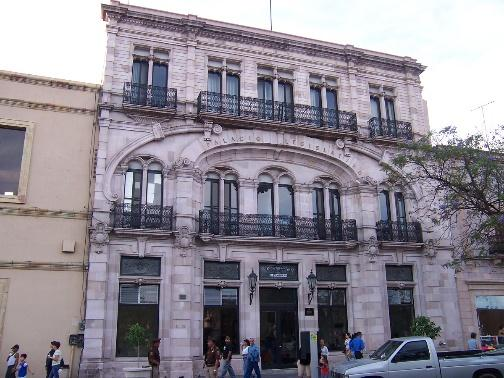

In [ ]:
import random
from PIL import Image
import matplotlib.pyplot as plt

all_images_path = list(image_path.glob("*/*.png"))

sample_image = random.choice(all_images_path)

img = Image.open(sample_image)
print(sample_image)
img

Here we are creating a custom dataset class to get the labels from the image filenames. We are encoding them as 0,1 and 2 to convert them to tensors later.

In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to a specific size
    transforms.ToTensor(),           # Convert PIL image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        self.labels = []

        for filename in os.listdir(root_dir):
            if filename.endswith(".png"):
                label_prefix = filename.split("_")[0]
                if label_prefix in ["Colonial", "Modern", "Prehispanic"]:
                    self.image_files.append(os.path.join(root_dir, filename))

                    if label_prefix == "Colonial":
                      self.labels.append(0)
                    elif label_prefix=="Modern":
                      self.labels.append(1)
                    else:
                      self.labels.append(2)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        label = self.labels[idx]
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
from torch.utils.data import DataLoader

train_dataset = CustomDataset(root_dir=train_dir, transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = CustomDataset(root_dir=val_dir, transform=data_transforms)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
#img, label = next(iter(train_loader))


Here I am going with the most basic approach, keeping the convolutional layer weights as they are and just adding one fully connected layer with input size 1024 and output size 3. Criteroion and cross entropy and optimizer is resnet. Since 0.001 learning rate tended to overfit in the training set a lot, I just halfed it in the second run. It is advised to try other optimizers like Adam.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset


# Load a pretrained ResNet model
resnet = models.resnet50(pretrained=True)

num_classes = 3  # Replace with the number of classes in your dataset
resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, num_classes),
    nn.LogSoftmax(dim=1)
)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.0005, momentum=0.9)


# Training loop
num_epochs = 11
resnet.to(device)
resnet

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 122MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Training loop for the dataset. To put the val scores in the graph for each epoch I am keeping track of each value in val set in every epoch. Normally I wouldn't do that.

In [ ]:
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    train_loss, train_acc = 0, 0
    val_loss, val_acc = 0, 0

    for images, labels in train_loader:
          # Setup train loss and train accuracy values

        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
              # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
        train_acc += (y_pred_class == labels).sum().item()/len(outputs)


    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(train_loader)
    train_acc = train_acc / len(train_loader)
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}] Training Loss: {train_loss:.4f} Training Acc: {train_acc:.4f}")

    resnet.eval()

    # Setup test loss and test accuracy values

    # Turn on inference context manager
    with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(val_loader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          val_pred_logits = resnet(X)

          # 2. Calculate and accumulate loss
          loss = criterion(val_pred_logits, y)
          val_loss += loss.item()

          # Calculate and accumulate accuracy
          val_pred_labels = val_pred_logits.argmax(dim=1)
          val_acc += ((val_pred_labels == y).sum().item()/len(val_pred_labels))

      # Adjust metrics to get average loss and accuracy per batch
      val_loss = val_loss / len(val_loader)
      val_acc = val_acc / len(val_loader)
      val_loss_list.append(val_loss)
      val_acc_list.append(val_acc)

      print(f"Epoch [{epoch + 1}/{num_epochs}] Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")

torch.save(resnet.state_dict(), "fine_tuned_resnet.pth")


Epoch [1/11] Training Loss: 1.0137 Training Acc: 0.4583
Epoch [1/11] Val Loss: 1.3916 Val Acc: 0.3125
Epoch [2/11] Training Loss: 0.7209 Training Acc: 0.6732
Epoch [2/11] Val Loss: 0.8507 Val Acc: 0.6719
Epoch [3/11] Training Loss: 0.4091 Training Acc: 0.8607
Epoch [3/11] Val Loss: 0.5433 Val Acc: 0.7500
Epoch [4/11] Training Loss: 0.1339 Training Acc: 0.9883
Epoch [4/11] Val Loss: 0.2524 Val Acc: 0.9062
Epoch [5/11] Training Loss: 0.0334 Training Acc: 1.0000
Epoch [5/11] Val Loss: 0.3478 Val Acc: 0.8906
Epoch [6/11] Training Loss: 0.0098 Training Acc: 1.0000
Epoch [6/11] Val Loss: 0.3951 Val Acc: 0.8906
Epoch [7/11] Training Loss: 0.0025 Training Acc: 1.0000
Epoch [7/11] Val Loss: 0.3519 Val Acc: 0.9062
Epoch [8/11] Training Loss: 0.0014 Training Acc: 1.0000
Epoch [8/11] Val Loss: 0.3946 Val Acc: 0.8906
Epoch [9/11] Training Loss: 0.0008 Training Acc: 1.0000
Epoch [9/11] Val Loss: 0.4288 Val Acc: 0.8906
Epoch [10/11] Training Loss: 0.0006 Training Acc: 1.0000
Epoch [10/11] Val Loss: 0

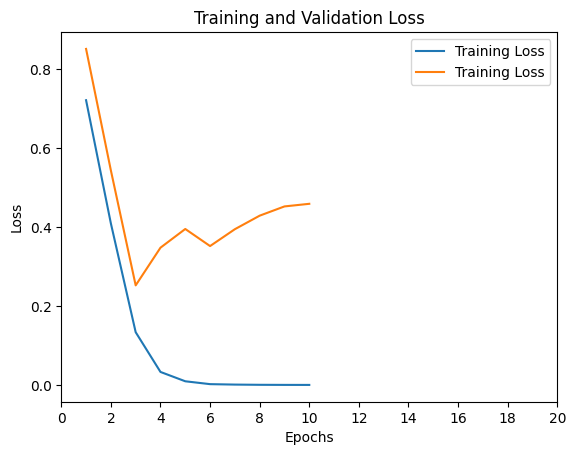

In [ ]:
from matplotlib.pylab import plt
from numpy import arange

# Load the training and validation loss dictionaries

# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, num_epochs)
# Plot and label the training and validation loss values
plt.plot(epochs, train_loss_list[1::], label='Training Loss')
plt.plot(epochs, val_loss_list[1::], label='Training Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(arange(0, 21, 2))

# Display the plot
plt.legend(loc='best')
plt.show()

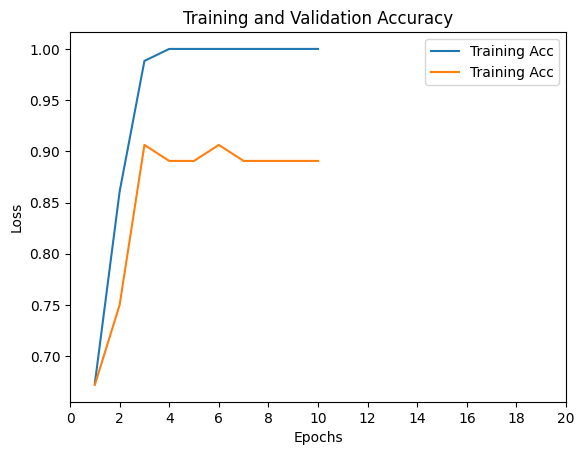

In [ ]:
from matplotlib.pylab import plt
from numpy import arange

# Load the training and validation loss dictionaries

# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, num_epochs)
# Plot and label the training and validation loss values
plt.plot(epochs, train_acc_list[1::], label='Training Acc')
plt.plot(epochs, val_acc_list[1::], label='Training Acc')

# Add in a title and axes labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(arange(0, 21, 2))

# Display the plot
plt.legend(loc='best')
plt.show()

In [ ]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [ ]:
import random
random.seed(42)
test_samples = []
test_labels = []
CLASSES = ["Colonial", "Modern", "Prehispanic"]
for sample, label in random.sample(list(val_dataset), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({CLASSES[test_labels[0]]})")


Test sample image shape: torch.Size([3, 224, 224])
Test sample label: 2 (Prehispanic)


In [ ]:
pred_probs= make_predictions(model=resnet,
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]


tensor([[3.0666e-07, 6.2341e-05, 9.9994e-01],
        [1.5532e-03, 7.8435e-04, 9.9766e-01]])

In [ ]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes


tensor([2, 2, 1, 0, 0, 2, 1, 0, 1])

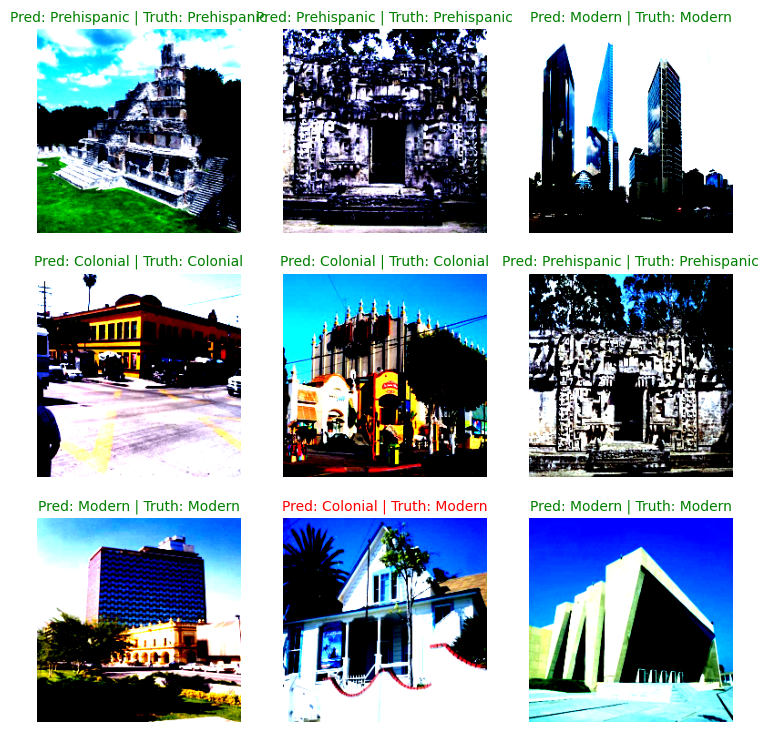

In [ ]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.permute(1,2,0), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = CLASSES[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = CLASSES[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);


In [ ]:
test_images = []
test_labels = []
for sample, label in list(val_dataset):
    test_images.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_images[0].shape}\nTest sample label: {test_labels[0]} ({CLASSES[test_labels[0]]})")


Test sample image shape: torch.Size([3, 224, 224])
Test sample label: 0 (Colonial)


In [ ]:
pred_probs= make_predictions(model=resnet,
                             data=test_images)


In [ ]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes


tensor([0, 1, 2, 2, 1, 1, 0, 2, 1, 2, 0, 0, 0, 2, 2, 0, 2, 0, 1, 1, 0, 0, 2, 0,
        0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 1, 2, 1, 0, 0, 0, 2, 1, 2, 2, 0, 2, 2, 2])

In [ ]:
CLASSES

['Colonial', 'Modern', 'Prehispanic']

In [ ]:
wrong_preds_class = []
x = 0
for i  in range(len(pred_classes)):
  if pred_classes[i] != test_labels[i]:
    if pred_classes[i] not in wrong_preds_class:
      wrong_preds_class.append(pred_classes[i])
    x+=1
print(len(wrong_preds_class))


1


There is only one image that our model classified wrong in the validation set. It is good !

<ipython-input-25-e3cbef27e587>:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(nrows, ncols, iter+1)


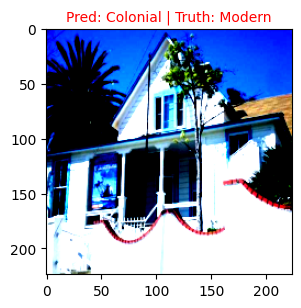

In [ ]:
# Plot predictions
plt.figure(figsize=(30, 30))
nrows = 8
ncols = 5
iter = 0
pred_labels = []
for i, sample in enumerate(test_images):
  # Create a subplot
  # Check for equality and change title colour accordingly
  pred_label = CLASSES[pred_classes[i]]

    # Get the truth CLASSES (in text form, e.g. "T-shirt")
  truth_label = CLASSES[test_labels[i]]

  if pred_label == truth_label:
    pass
  else:
    if iter<40 and (pred_label not in pred_labels):
      pred_labels.append(pred_label)
      plt.subplot(nrows, ncols, iter+1)

      # Plot the target image
      plt.imshow(sample.permute(1,2,0), cmap="gray")

      # Find the prediction label (in text form, e.g. "Sandal")

      # Create the title text of the plot
      title_text = f"Pred: {pred_label} | Truth: {truth_label}"


      plt.title(title_text, fontsize=10, c="r") # red text if wrong
      iter += 1
  plt.axis(True);
